In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma
from cvx.covariance.combination import from_sigmas
from experiments.utils.experiment_utils import *
from experiments.utils.iterated_ewma_vec import ewma

sns.set()
sns.set(font_scale=1.5)

In [3]:
returns = pd.read_csv('../data/ff5_no_rf.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [10]:
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]

# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

100%|██████████| 14845/14845 [01:24<00:00, 175.34it/s]


In [4]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("../mgarch_predictors_from_R/factor_returns/mgarch_ff5.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}
cm_iewma = mgarch

In [5]:
# Prescient
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

# EWMA smoothing

In [6]:
def ewma_smoothing(Sigmas, halflife):
    Sigmas_vec = np.array([*cm_iewma.values()])
    Sigmas_smoothed = ewma(Sigmas_vec, halflife=halflife)

    return {time: pd.DataFrame(Sigmas_smoothed[i], index=returns.columns, columns=returns.columns) for i, time in enumerate(cm_iewma.keys())}

def frob_difference(Sigmas):

    frob_diffs = np.zeros(len(Sigmas)-1)
    times = list(Sigmas.keys())

    for i, (time, Sigma) in enumerate(Sigmas.items()):
        if i == 0:
            continue
        frob_diffs[i-1] = np.linalg.norm(Sigma - Sigmas[list(Sigmas.keys())[i-1]], ord='fro') / np.linalg.norm(Sigmas[list(Sigmas.keys())[i-1]], ord='fro')

    return pd.Series(frob_diffs, index=times[1:])

In [7]:
Sigmas_0p5 = ewma_smoothing(cm_iewma, halflife=0.5)
Sigmas_1 = ewma_smoothing(cm_iewma, halflife=1)
Sigmas_2p5 = ewma_smoothing(cm_iewma, halflife=2.5)
Sigmas_5 = ewma_smoothing(cm_iewma, halflife=5)
Sigmas_10 = ewma_smoothing(cm_iewma, halflife=10)
Sigmas_20 = ewma_smoothing(cm_iewma, halflife=20)
Sigmas_50 = ewma_smoothing(cm_iewma, halflife=50)
Sigmas_100 = ewma_smoothing(cm_iewma, halflife=100)
Sigmas_250 = ewma_smoothing(cm_iewma, halflife=250)
Sigmas_5000 = ewma_smoothing(cm_iewma, halflife=5000)

In [8]:
start_date = [*cm_iewma.keys()][0]
end_date = [*cm_iewma.keys()][-1]

names = ['No smoothing',  '0.5', '1', '2p5', '5', '10', '20', '50', '100', '250', '5000']
all_Sigmas = [cm_iewma, Sigmas_0p5, Sigmas_1, Sigmas_2p5, Sigmas_5, Sigmas_10, Sigmas_20, Sigmas_50, Sigmas_100, Sigmas_250, Sigmas_5000]

prescient = {time: prescient[time] for time in cm_iewma.keys()}


In [9]:
frob_diffs = {}
frob_diffs['No smoothing'] = frob_difference(cm_iewma)
frob_diffs['0p5'] = frob_difference(Sigmas_0p5)
frob_diffs['1'] = frob_difference(Sigmas_1)
frob_diffs['2p5'] = frob_difference(Sigmas_2p5)
frob_diffs['5'] = frob_difference(Sigmas_5)
frob_diffs['10'] = frob_difference(Sigmas_10)
frob_diffs['20'] = frob_difference(Sigmas_20)
frob_diffs['50'] = frob_difference(Sigmas_50)
frob_diffs['100'] = frob_difference(Sigmas_100)
frob_diffs['250'] = frob_difference(Sigmas_250)
frob_diffs['5000'] = frob_difference(Sigmas_5000)

In [10]:
log_likelihoods = {}
for i, Sigmas in enumerate(all_Sigmas):
    ll = log_likelihood_regularized(returns.loc[start_date:end_date], Sigmas)
    log_likelihoods[names[i]] = ll

ll_prescient = log_likelihood_regularized(returns.loc[start_date:end_date], prescient)
log_likelihoods['PRESCIENT'] = ll_prescient

In [1]:
from experiments.utils.experiment_utils import log_likelihood_regularized

In [11]:
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

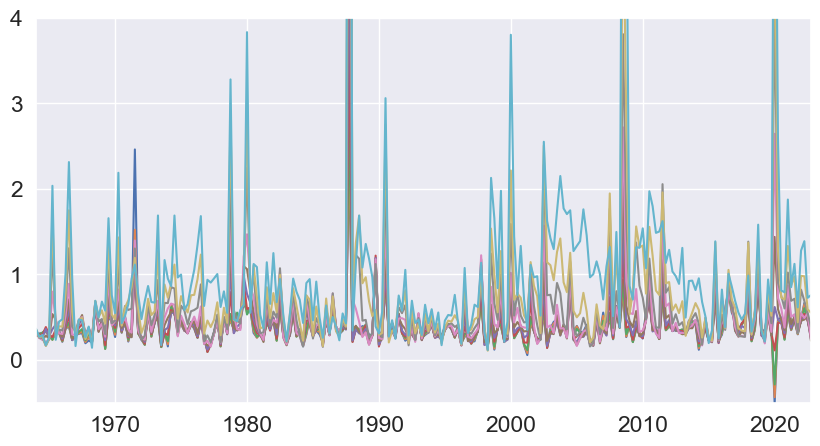

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
# plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.ylim(-0.5,4);

In [13]:
avg_regrets = {}
for name in regrets:
    avg_regrets[name] = regrets[name].mean()

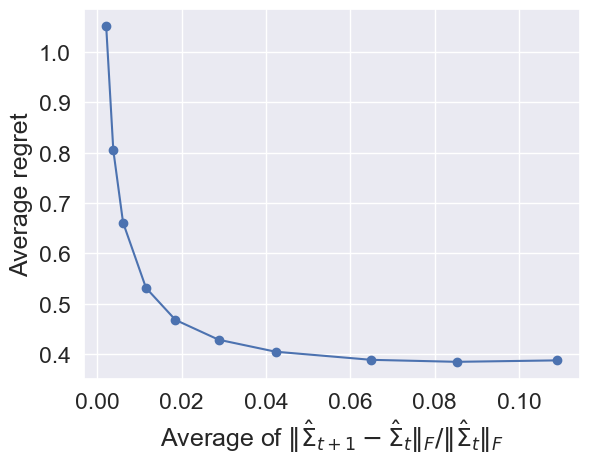

In [318]:
frob_diff_means = [frob_diff.mean() for frob_diff in frob_diffs.values()]
log_likelihood_means = [log_likelihoods[name].mean() for name in log_likelihoods.keys() if name!='PRESCIENT']
regret_means = [avg_regrets[name] for name in avg_regrets.keys() if name!='PRESCIENT']

# plt.figure()
# plt.plot(frob_diff_means, log_likelihood_means, 'o');

plt.figure()
plt.plot(frob_diff_means, regret_means, marker='o');

plt.ylabel("Average regret")
plt.xlabel(r"Average of $\|\hat\Sigma_{t+1}-\hat\Sigma_{t}\|_F/\|\hat\Sigma_{t}\|_F$");

### Minimum risk portfolio

In [19]:
from experiments.utils.portfolio_backtests import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

# Volatility target
sigma_tar = 0.02
excess = False

def turnover(weights):
    """
    Computes average turnover for a sequence of weights,
    i.e., mean of |w_{t+1}-w_{t}|_1
    """
    w_diff = weights[1:] - weights[:-1]

    return np.mean(np.sum(np.abs(w_diff), axis=1))

In [319]:
predictors = [cm_iewma, Sigmas_0p5, Sigmas_1, Sigmas_2p5, Sigmas_5, Sigmas_10, Sigmas_20, Sigmas_50, Sigmas_100, Sigmas_250]
traders_min_risk_ewma = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 10/10 [14:45<00:00, 88.58s/it]


In [21]:
create_table(traders_min_risk_ewma, sigma_tar, rf, excess, prescient=False)

NameError: name 'traders_min_risk_ewma' is not defined

In [350]:
for name, trader in traders_min_risk_ewma.items():
    print("\n" + name, turnover(trader.ws_diluted))


No smoothing 0.050420210253128386

0.5 0.04019769497662156

1 0.030767339252129603

2p5 0.01940964434214651

5 0.012595315118756409

10 0.00767564208499946

20 0.004501967406932064

50 0.0022260407307871234

100 0.0013533458211059883

250 0.0007559434110245107

2500 0.00027721806041230995

5000 0.00024241777859410407


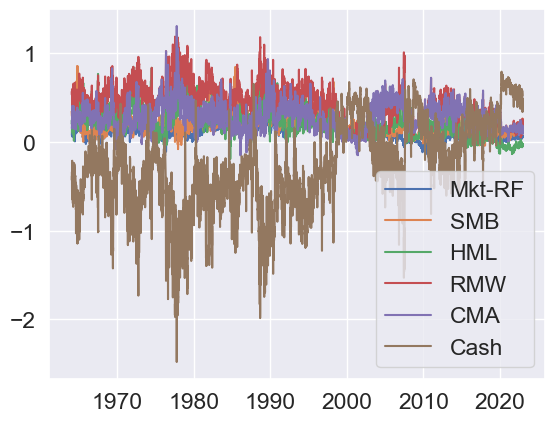

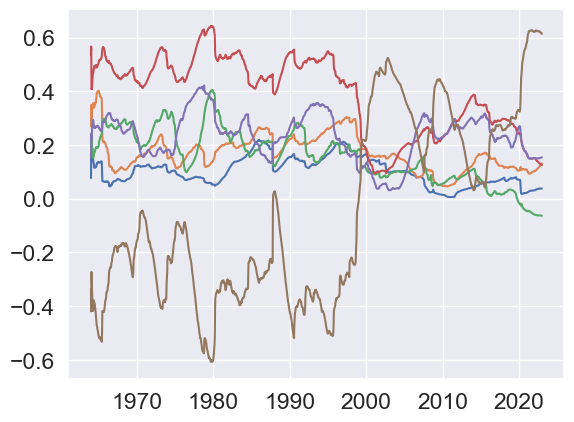

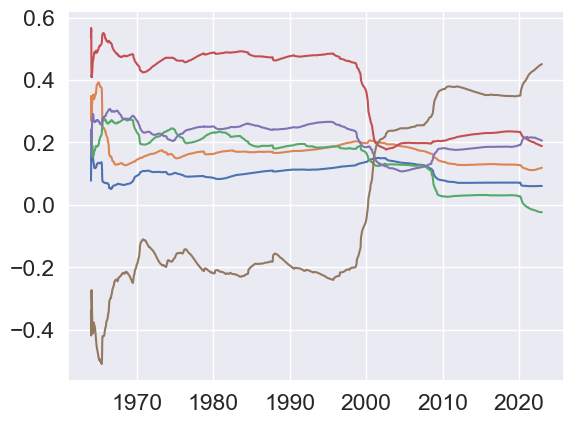

In [351]:
labels = list(returns.columns) + ['Cash']

times = [*traders_min_risk_ewma.values()][0].R.index
plt.figure()
plt.plot(times, traders_min_risk_ewma['No smoothing'].ws_diluted, label=labels);
plt.legend();

plt.figure()
plt.plot(times, traders_min_risk_ewma['250'].ws_diluted, label=labels);

plt.figure()
plt.plot(times, traders_min_risk_ewma['5000'].ws_diluted, label=labels);

# L1 smoothing

In [107]:
n = returns.shape[1]
def get_next(Sigma_unsmooth, Sigma_prev, lamda):
    theta = cp.Variable()
    Xt = cp.Parameter((n,n), PSD=True)
    Y_old = cp.Parameter((n,n), PSD=True)

    Yt = theta*Xt + (1-theta)*Y_old

    Xt.value = Sigma_unsmooth
    Y_old.value = Sigma_prev

    obj = 1/2*cp.norm(Yt-Xt, "fro")**2 + lamda*cp.norm(Yt-Y_old, "fro")

    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    return Yt.value

def L1_smoothing(Sigmas, lamda0=0.1): #, greedy=False):
    times = [*Sigmas.keys()]
    Sigmas = np.array([*Sigmas.values()])

    Sigmas_smoothed = np.zeros_like(Sigmas)
    Sigmas_smoothed[0] = Sigmas[0]

    updates = []
    for i in trange(1, len(Sigmas)):
        lamda = lamda0 #* np.linalg.norm(Sigmas[i], "fro")
        Sigma_prev = Sigmas_smoothed[i-1]
        Sigma_unsmooth = Sigmas[i]
        if np.linalg.norm(Sigma_prev-Sigma_unsmooth, "fro")<=lamda:
            Sigmas_smoothed[i] = Sigma_prev
            updates.append(0)

        else:
            # if not greedy:
            Sigmas_smoothed[i] = get_next(Sigma_unsmooth, Sigma_prev, lamda)
            updates.append(1)
            # else:
            #     Sigmas_smoothed[i] = Sigma_unsmooth
    Sigmas_smoothed = {time: pd.DataFrame(Sigma, index=returns.columns, columns=returns.columns) for time, Sigma in zip(times, Sigmas_smoothed)}
    return Sigmas_smoothed, updates

In [101]:
Sigmas_001, updates001 = L1_smoothing(cm_iewma, lamda0=0.00001)

100%|██████████| 14844/14844 [02:13<00:00, 110.92it/s]


In [131]:
Sigmas_000025, updates000025 = L1_smoothing(cm_iewma, lamda0=0.000025)
Sigmas_00005, updates00005 = L1_smoothing(cm_iewma, lamda0=0.00005)
Sigmas_000075, updates000075 = L1_smoothing(cm_iewma, lamda0=0.000075)

100%|██████████| 14844/14844 [00:18<00:00, 790.77it/s] 


In [108]:
Sigmas_000001, updates000001 = L1_smoothing(cm_iewma, lamda0=0.000001)
Sigmas_00001, updates00001 = L1_smoothing(cm_iewma, lamda0=0.00001)
Sigmas_000025, updates000025 = L1_smoothing(cm_iewma, lamda0=0.000025)
Sigmas_00005, updates00005 = L1_smoothing(cm_iewma, lamda0=0.00005)
Sigmas_000075, updates000075 = L1_smoothing(cm_iewma, lamda0=0.000075)
Sigmas_0001, updates0001 = L1_smoothing(cm_iewma, lamda0=0.0001)
Sigmas_001, updates001 = L1_smoothing(cm_iewma, lamda0=0.001)
Sigmas_0025, updates0025 = L1_smoothing(cm_iewma, lamda0=0.0025)
Sigmas_005, updates005 = L1_smoothing(cm_iewma, lamda0=0.005)
Sigmas_0075, updates0075 = L1_smoothing(cm_iewma, lamda0=0.0075)

100%|██████████| 14844/14844 [00:00<00:00, 171710.73it/s]


In [201]:
names = ['No smoothing', '0.000001', '0.00001', '0.000025', '0.00005', '0.000075', '0.0001', '0.001', '0.0025', '0.005', '0.0075']

all_Sigmas = [cm_iewma, Sigmas_000001, Sigmas_00001, Sigmas_000025, Sigmas_00005, Sigmas_000075, Sigmas_0001, Sigmas_001, Sigmas_0025, Sigmas_005, Sigmas_0075]
all_updates = [updates000001, updates00001, updates000025, updates00005, updates000075, updates0001, updates001, updates0025, updates005, updates0075]

In [338]:
1/ np.mean(updates0001)

16.438538205980066

In [202]:
log_likelihoods = {}
for i, Sigmas in enumerate(all_Sigmas):
    ll = log_likelihood_regularized(returns.loc[start_date:end_date], Sigmas)
    log_likelihoods[names[i]] = ll

ll_prescient = log_likelihood_regularized(returns.loc[start_date:end_date], prescient)
log_likelihoods['PRESCIENT'] = ll_prescient

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

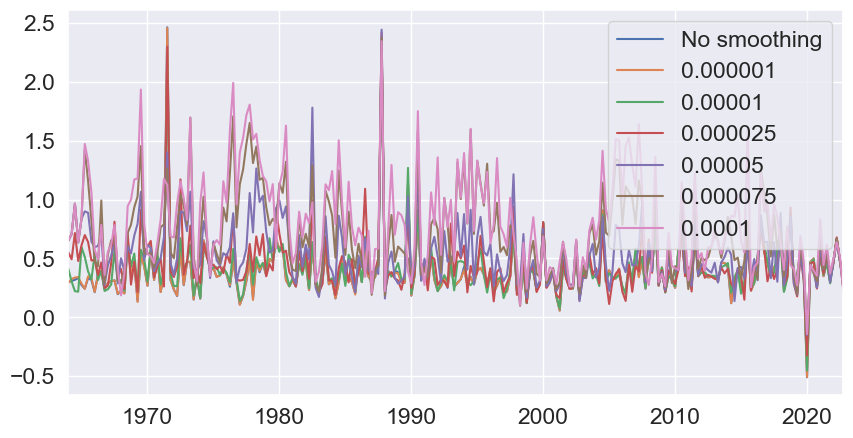

In [270]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names[:-4]:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend();
# plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
# plt.ylim(-0.5,4);

/var/folders/mr/mp0qg4bx6sj56pg6fs3s65kc0000gr/T/ipykernel_7899/1589837669.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  mean_updates_every = [1/mean for mean in mean_days_between_updates]


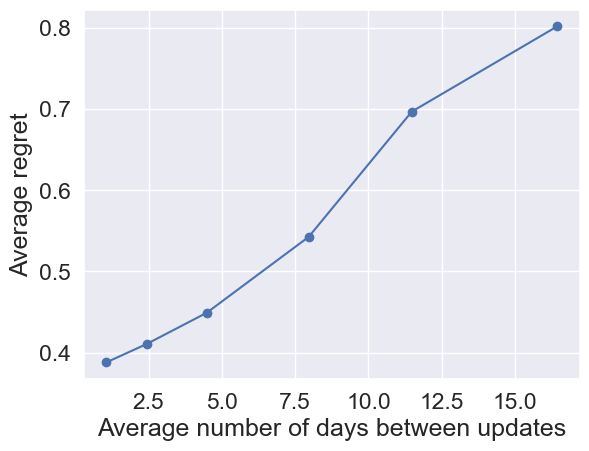

In [206]:
mean_days_between_updates = [1]+[np.mean(update) for update in all_updates]
mean_updates_every = [1/mean for mean in mean_days_between_updates]
avg_regrets = {}
for name in regrets:
    avg_regrets[name] = regrets[name].mean()
mean_regrets = [avg_regrets[name] for name in avg_regrets.keys() if name!='PRESCIENT']

plt.plot(mean_updates_every[1:-4], mean_regrets[1:-4], marker='o');
plt.xlabel("Average number of days between updates")
plt.ylabel("Average regret");


### Minimum risk portfolio

In [213]:
predictors = all_Sigmas 

In [214]:
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 11/11 [09:59<00:00, 54.53s/it]


In [215]:
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   No smoothing & 1.2\% & 2.1\% & 0.5 & 21\% \\
   0.000001 & 1.2\% & 2.1\% & 0.5 & 21\% \\
   0.00001 & 1.2\% & 2.1\% & 0.6 & 19\% \\
   0.000025 & 1.6\% & 2.1\% & 0.8 & 17\% \\
   0.00005 & 1.9\% & 2.0\% & 1.0 & 14\% \\
   0.000075 & 2.2\% & 1.9\% & 1.1 & 12\% \\
   0.0001 & 2.4\% & 1.9\% & 1.3 & 9\% \\
   0.001 & 2.6\% & 2.1\% & 1.2 & 17\% \\
   0.0025 & 2.8\% & 2.3\% & 1.2 & 17\% \\
   0.005 & 3.0\% & 2.8\% & 1.1 & 17\% \\
   0.0075 & 3.0\% & 4.8\% & 0.6 & 31\% \\
   \hline
   \bottomrule
\end{tabular}


In [325]:
for name, trader in traders_min_risk.items():
    print("\n" + name, turnover(trader.ws_diluted))


No smoothing 0.050420252169065094

0.000001 0.04921304496486615

0.00001 0.03190782459693568

0.000025 0.012860938722038178

0.00005 0.006283009063529766

0.000075 0.004071336938603459

0.0001 0.003114746971205462

0.001 0.0001976085153740446

0.0025 5.484126271235841e-05

0.005 2.3551250775711437e-05

0.0075 0.0


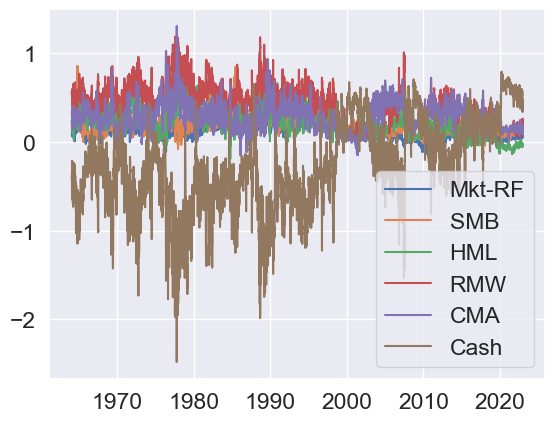

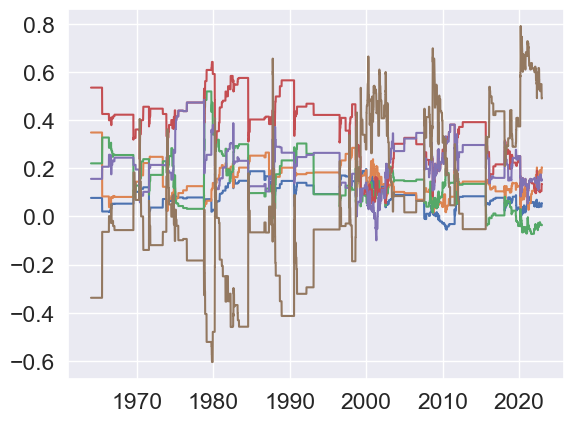

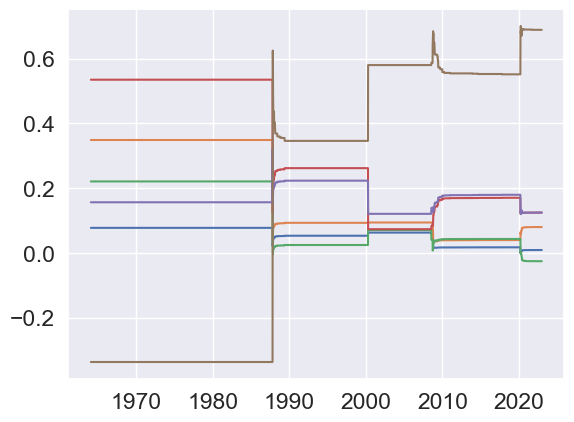

In [332]:
labels = list(returns.columns) + ['Cash']

times = [*traders_min_risk.values()][0].R.index
plt.figure()
plt.plot(times, traders_min_risk['No smoothing'].ws_diluted, label=labels);
plt.legend();

plt.figure()
plt.plot(times, traders_min_risk['0.0001'].ws_diluted, label=labels);

plt.figure()
plt.plot(times, traders_min_risk['0.001'].ws_diluted, label=labels);